# Project Intro
Forecast sales using store, promotion, and competitor data

Rossmann operates over 3,000 drug stores in 7 European countries. Currently, 
Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. 

---
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

### Files

1. train.csv - historical data including Sales
1. test.csv - historical data excluding Sales
1. sample_submission.csv - a sample submission file in the correct format
1. store.csv - supplemental information about the stores
### Data fields

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

[Link to Kaggle](https://www.kaggle.com/c/rossmann-store-sales)

# Import Data and Libraries

In [1]:
%matplotlib inline
import numba

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import math
from datetime import datetime
from datetime import timedelta

from pandas.tools.plotting import scatter_matrix
from pandas.tools.plotting import autocorrelation_plot
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm  
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

import gc

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
plt.rcParams['agg.path.chunksize'] = 100000

In [4]:
store_raw = pd.read_csv('store.csv')
test_raw = pd.read_csv('test.csv')
train_raw = pd.read_csv('train.csv')

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
store_raw.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [6]:
store_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [7]:
train_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [8]:
test_raw.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [9]:
train_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [10]:
test_raw.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1


In [11]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null object
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null object
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


# Data Wrangling

## merge two tables

In [13]:
train_store_raw = train_raw.merge(store_raw, on='Store', how='left')
test_store_raw = test_raw.merge(store_raw, on='Store',how='left')

## change column types

In [14]:
train_store_raw['Date_formatted'] = pd.to_datetime(train_store_raw['Date'], format='%Y-%m-%d')
test_store_raw['Date_formatted'] = pd.to_datetime(test_store_raw['Date'], format='%Y-%m-%d')

## convert StateHolidays
a = public holiday, b = Easter holiday, c = Christmas, 0 = None

In [15]:
state_holidays = {'a':1, 'b':2, 'c':3, '0':0}

train_store_raw['StateHolidy_formatted'] = train_store_raw['StateHoliday'].replace(state_holidays)
test_store_raw['StateHolidy_formatted'] = test_store_raw['StateHoliday'].replace(state_holidays)

## replace StoreType
 differentiates between 4 different store models: a, b, c, d

In [16]:
store_types = {'a':0, 'b':1, 'c':2, 'd':3}
train_store_raw['StoreType_formatted'] = train_store_raw['StoreType'].replace(store_types)
test_store_raw['StoreType_formatted'] = test_store_raw['StoreType'].replace(store_types)

# replace Assortment
# describes an assortment level: a = basic, b = extra, c = extended

assortments = {'a':0, 'b':1, 'c':2}
train_store_raw['Assortment_formatted'] = train_store_raw['Assortment'].replace(assortments)
test_store_raw['Assortment_formatted'] = test_store_raw['Assortment'].replace(assortments)

## convert PromoInteval

In [17]:
def formatPromoInterval(string):
    intervals={'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
    if pd.notnull(string):
        months = intervals[string]
    else:
        months = 0
    return months

In [18]:
train_store_raw['PromoInterval_formatted'] = train_store_raw['PromoInterval'].apply(lambda x: formatPromoInterval(x))
test_store_raw['PromoInterval_formatted'] = test_store_raw['PromoInterval'].apply(lambda x: formatPromoInterval(x))

In [19]:
train_store_raw.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_formatted,StateHolidy_formatted,StoreType_formatted,Assortment_formatted,PromoInterval_formatted
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2013-01-01,1,0,0,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2013-01-01,1,2,2,0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2013-01-01,1,0,2,0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2013-01-01,1,0,2,0
1017208,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2013-01-01,1,3,2,3


In [20]:
test_store_raw.tail()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Date_formatted,StateHolidy_formatted,StoreType_formatted,Assortment_formatted,PromoInterval_formatted
41083,41084,1111,6,2015-08-01,1.0,0,0,0,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",2015-08-01,0,0,0,1
41084,41085,1112,6,2015-08-01,1.0,0,0,0,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN,2015-08-01,0,2,2,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN,2015-08-01,0,0,2,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN,2015-08-01,0,0,2,0
41087,41088,1115,6,2015-08-01,1.0,0,0,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec",2015-08-01,0,3,2,3


In [21]:
train_ready = train_store_raw[['Store', 'DayOfWeek','Date_formatted', 'Sales', 'Customers', 'Open', 'Promo', 'StateHolidy_formatted', 'SchoolHoliday', 'StoreType_formatted', 'Assortment_formatted', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval_formatted']]
test_ready = test_store_raw[['Id','Store', 'DayOfWeek','Date_formatted', 'Open', 'Promo', 'StateHolidy_formatted', 'SchoolHoliday', 'StoreType_formatted', 'Assortment_formatted', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval_formatted']]

In [22]:
avg = np.average(train_ready['CompetitionOpenSinceMonth'][train_ready['CompetitionOpenSinceMonth'].isnull() == False])

train_ready['CompetitionOpenSinceMonth'].fillna(avg, inplace=True)

avg = np.average(train_ready['CompetitionOpenSinceYear'][train_ready['CompetitionOpenSinceYear'].isnull() == False])

train_ready['CompetitionOpenSinceYear'].fillna(avg, inplace=True)

avg = np.average(train_ready['CompetitionDistance'][train_ready['CompetitionDistance'].isnull() == False])

train_ready['CompetitionDistance'].fillna(avg, inplace=True)

avg = np.average(train_ready['Promo2SinceWeek'][train_ready['Promo2SinceWeek'].isnull() == False])

train_ready['Promo2SinceWeek'].fillna(avg, inplace=True)

avg = np.average(train_ready['Promo2SinceYear'][train_ready['Promo2SinceYear'].isnull() == False])

train_ready['Promo2SinceYear'].fillna(avg, inplace=True)

print train_ready['Store'].isnull().values.any()
print train_ready['DayOfWeek'].isnull().values.any()
print train_ready['Customers'].isnull().values.any()
print train_ready['Open'].isnull().values.any()
print train_ready['Promo'].isnull().values.any()
print train_ready['StateHolidy_formatted'].isnull().values.any()
print train_ready['SchoolHoliday'].isnull().values.any()
print train_ready['StoreType_formatted'].isnull().values.any()
print train_ready['Assortment_formatted'].isnull().values.any()
print train_ready['CompetitionDistance'].isnull().values.any()
print train_ready['CompetitionOpenSinceMonth'].isnull().values.any()
print train_ready['CompetitionOpenSinceYear'].isnull().values.any()
print train_ready['Promo2'].isnull().values.any()
print train_ready['Promo2SinceWeek'].isnull().values.any()
print train_ready['Promo2SinceYear'].isnull().values.any()
print train_ready['PromoInterval_formatted'].isnull().values.any()

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [23]:
avg = np.average(test_ready['CompetitionOpenSinceMonth'][test_ready['CompetitionOpenSinceMonth'].isnull() == False])

test_ready['CompetitionOpenSinceMonth'].fillna(avg, inplace=True)

avg = np.average(test_ready['CompetitionOpenSinceYear'][test_ready['CompetitionOpenSinceYear'].isnull() == False])

test_ready['CompetitionOpenSinceYear'].fillna(avg, inplace=True)

avg = np.average(test_ready['CompetitionDistance'][test_ready['CompetitionDistance'].isnull() == False])

test_ready['CompetitionDistance'].fillna(avg, inplace=True)

avg = np.average(test_ready['Promo2SinceWeek'][test_ready['Promo2SinceWeek'].isnull() == False])

test_ready['Promo2SinceWeek'].fillna(avg, inplace=True)

avg = np.average(test_ready['Promo2SinceYear'][test_ready['Promo2SinceYear'].isnull() == False])

test_ready['Promo2SinceYear'].fillna(avg, inplace=True)

print test_ready['Store'].isnull().values.any()
print test_ready['DayOfWeek'].isnull().values.any()
print test_ready['Open'].isnull().values.any()
print test_ready['Promo'].isnull().values.any()
print test_ready['StateHolidy_formatted'].isnull().values.any()
print test_ready['SchoolHoliday'].isnull().values.any()
print test_ready['StoreType_formatted'].isnull().values.any()
print test_ready['Assortment_formatted'].isnull().values.any()
print test_ready['CompetitionDistance'].isnull().values.any()
print test_ready['CompetitionOpenSinceMonth'].isnull().values.any()
print test_ready['CompetitionOpenSinceYear'].isnull().values.any()
print test_ready['Promo2'].isnull().values.any()
print test_ready['Promo2SinceWeek'].isnull().values.any()
print test_ready['Promo2SinceYear'].isnull().values.any()
print test_ready['PromoInterval_formatted'].isnull().values.any()

False
False
True
False
False
False
False
False
False
False
False
False
False
False
False


In [24]:
train_ready['Date_year'] = train_ready['Date_formatted'].apply(lambda x: x.year)
train_ready['Date_month'] = train_ready['Date_formatted'].apply(lambda x: x.month)
train_ready['Date_day'] = train_ready['Date_formatted'].apply(lambda x: x.day)

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [25]:
test_ready['Date_year'] = test_ready['Date_formatted'].apply(lambda x: x.year)
test_ready['Date_month'] = test_ready['Date_formatted'].apply(lambda x: x.month)
test_ready['Date_day'] = test_ready['Date_formatted'].apply(lambda x: x.day)

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [26]:
train_ready.head()

,Store,DayOfWeek,Date_formatted,Sales,Customers,Open,Promo,StateHolidy_formatted,SchoolHoliday,StoreType_formatted,Assortment_formatted,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_formatted,Date_year,Date_month,Date_day
0,1,5,2015-07-31,5263,555,1,1,0,1,2,0,1270.0,9.0,2008.0,0,23.269093,2011.752774,0,2015,7,31
1,2,5,2015-07-31,6064,625,1,1,0,1,0,0,570.0,11.0,2007.0,1,13.000000,2010.000000,1,2015,7,31
2,3,5,2015-07-31,8314,821,1,1,0,1,0,0,14130.0,12.0,2006.0,1,14.000000,2011.000000,1,2015,7,31
3,4,5,2015-07-31,13995,1498,1,1,0,1,2,2,620.0,9.0,2009.0,0,23.269093,2011.752774,0,2015,7,31
4,5,5,2015-07-31,4822,559,1,1,0,1,0,0,29910.0,4.0,2015.0,0,23.269093,2011.752774,0,2015,7,31


In [27]:
train_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 21 columns):
Store                        1017209 non-null int64
DayOfWeek                    1017209 non-null int64
Date_formatted               1017209 non-null datetime64[ns]
Sales                        1017209 non-null int64
Customers                    1017209 non-null int64
Open                         1017209 non-null int64
Promo                        1017209 non-null int64
StateHolidy_formatted        1017209 non-null int64
SchoolHoliday                1017209 non-null int64
StoreType_formatted          1017209 non-null int64
Assortment_formatted         1017209 non-null int64
CompetitionDistance          1017209 non-null float64
CompetitionOpenSinceMonth    1017209 non-null float64
CompetitionOpenSinceYear     1017209 non-null float64
Promo2                       1017209 non-null int64
Promo2SinceWeek              1017209 non-null float64
Promo2SinceYear              1017209 n

In [28]:
test_ready.head()

,Id,Store,DayOfWeek,Date_formatted,Open,Promo,StateHolidy_formatted,SchoolHoliday,StoreType_formatted,Assortment_formatted,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_formatted,Date_year,Date_month,Date_day
0,1,1,4,2015-09-17,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,2015,9,17
1,2,3,4,2015-09-17,1.0,1,0,0,0,0,14130.0,12.0,2006.0,1,14.000000,2011.000000,1,2015,9,17
2,3,7,4,2015-09-17,1.0,1,0,0,0,2,24000.0,4.0,2013.0,0,24.426559,2011.820926,0,2015,9,17
3,4,8,4,2015-09-17,1.0,1,0,0,0,0,7520.0,10.0,2014.0,0,24.426559,2011.820926,0,2015,9,17
4,5,9,4,2015-09-17,1.0,1,0,0,0,2,2030.0,8.0,2000.0,0,24.426559,2011.820926,0,2015,9,17


In [29]:
test_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 20 columns):
Id                           41088 non-null int64
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date_formatted               41088 non-null datetime64[ns]
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHolidy_formatted        41088 non-null int64
SchoolHoliday                41088 non-null int64
StoreType_formatted          41088 non-null int64
Assortment_formatted         41088 non-null int64
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval_formatted      41088 non-null int64
Date_year           

# Data Explore

In [71]:
train_ready.columns

Index([u'Store', u'DayOfWeek', u'Date_formatted', u'Sales', u'Customers',
       u'Open', u'Promo', u'StateHolidy_formatted', u'SchoolHoliday',
       u'StoreType_formatted', u'Assortment_formatted', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval_formatted',
       u'Date_year', u'Date_month', u'Date_day'],
      dtype='object')

In [91]:
feature_columns = [u'Store', u'DayOfWeek', u'Promo', u'StateHolidy_formatted', u'SchoolHoliday',
       u'StoreType_formatted', u'Assortment_formatted', u'CompetitionDistance',
       u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2',
       u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval_formatted',
       u'Date_year', u'Date_month', u'Date_day']
target_coumn = ['Sales']

In [73]:
train_ready_g = train_ready.groupby('Store')

In [74]:
g1 = train_ready_g.get_group(1)

In [75]:
# let's run it store by store

In [82]:
g1_open = g1[g1['Open']==1]
train_size = int(len(g1_open)*.6)
g1_open_train = g1.head(train_size)
g1_open_test = g1.ix[train_size:]

In [118]:
rfr = RandomForestRegressor(n_estimators=500, n_jobs=4, oob_score=True)
model = rfr.fit(g1_open_train[feature_columns], g1_open_train[target_coumn])

/Users/zhangxinzhou/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [119]:
print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rfr.feature_importances_), feature_columns), 
             reverse=True)

Features sorted by their score:
[(0.6564, u'DayOfWeek'), (0.1665, u'StateHolidy_formatted'), (0.0702, u'Date_month'), (0.0551, u'Date_day'), (0.0462, u'Promo'), (0.0031, u'SchoolHoliday'), (0.0025, u'Date_year'), (0.0, u'StoreType_formatted'), (0.0, u'Store'), (0.0, u'PromoInterval_formatted'), (0.0, u'Promo2SinceYear'), (0.0, u'Promo2SinceWeek'), (0.0, u'Promo2'), (0.0, u'CompetitionOpenSinceYear'), (0.0, u'CompetitionOpenSinceMonth'), (0.0, u'CompetitionDistance'), (0.0, u'Assortment_formatted')]


In [120]:
g1_open_preds = rfr.predict(g1_open_test[feature_columns])

('MSE: ', 359019.08289701265)
('oob: ', 0.93041286305715476)


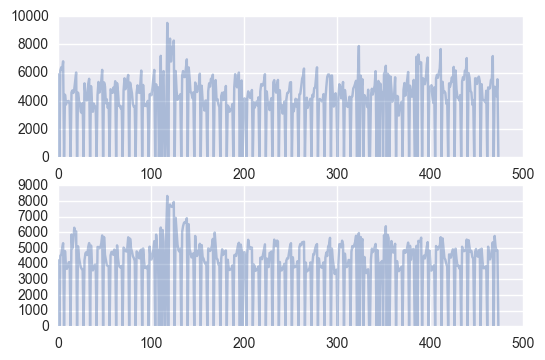

In [122]:
print('MSE: ', mean_squared_error(g1_open_test[target_coumn].values, g1_open_preds))
print('oob: ', rfr.oob_score_)
plt.subplot(2, 1, 1)
plt.plot(g1_open_test[target_coumn].values, alpha=.4)
plt.subplot(2, 1, 2)
plt.plot(g1_open_preds, alpha=.4)

# Predict

In [555]:
test_ready_g.get_group(1)

,Store,DayOfWeek,Date_formated,Open,Promo,StateHolidy_formatted,SchoolHoliday,StoreType_formatted,Assortment_formatted,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval_formatted,EpochTime,DayOfYear,CompetitionOpenSinceDays,Promo2SinceDays
0,1,4,2015-09-17,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442448000000000000,260,2572.0,NaN
1,1,3,2015-09-16,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442361600000000000,259,2571.0,NaN
2,1,2,2015-09-15,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442275200000000000,258,2570.0,NaN
3,1,1,2015-09-14,1.0,1,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442188800000000000,257,2569.0,NaN
4,1,7,2015-09-13,0.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442102400000000000,256,2568.0,NaN
5,1,6,2015-09-12,1.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1442016000000000000,255,2567.0,NaN
6,1,5,2015-09-11,1.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1441929600000000000,254,2566.0,NaN
7,1,4,2015-09-10,1.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1441843200000000000,253,2565.0,NaN
8,1,3,2015-09-09,1.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1441756800000000000,252,2564.0,NaN
9,1,2,2015-09-08,1.0,0,0,0,2,0,1270.0,9.0,2008.0,0,24.426559,2011.820926,0,1441670400000000000,251,2563.0,NaN


In [561]:
test_ready.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 20 columns):
Store                        41088 non-null int64
DayOfWeek                    41088 non-null int64
Date_formated                41088 non-null datetime64[ns]
Open                         41077 non-null float64
Promo                        41088 non-null int64
StateHolidy_formatted        41088 non-null int64
SchoolHoliday                41088 non-null int64
StoreType_formatted          41088 non-null int64
Assortment_formatted         41088 non-null int64
CompetitionDistance          41088 non-null float64
CompetitionOpenSinceMonth    41088 non-null float64
CompetitionOpenSinceYear     41088 non-null float64
Promo2                       41088 non-null int64
Promo2SinceWeek              41088 non-null float64
Promo2SinceYear              41088 non-null float64
PromoInterval_formatted      41088 non-null int64
EpochTime                    41088 non-null int64
DayOfYear           

In [343]:
pred1 = rfr.predict(test_ready_with_ts1[feature_columns])

In [344]:
df1 = pd.DataFrame(pred1, columns=['Sales'])

In [345]:
df1['Id'] = range(1, len(df1)+1)

In [346]:
df1 = df1[['Id','Sales']]

In [347]:
df1.columns

Index([u'Id', u'Sales'], dtype='object')

In [348]:
df1.to_csv('pred1.csv', index=False)